In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import pathlib, os, random
from pathlib import Path
classes=["broccoli", "cauliflower", "unknown"]
splits=["test", "train", "validate"]

2025-07-10 22:23:06.296281: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEED        = 88
ROOT        = pathlib.Path("Dataset for CA1 part A - AY2526S1")  # <-- adjust path if needed
IMG_SIZE    = (224, 224)    # load at original size first
BATCH_SIZE  = 256
LABEL_MODE  = "categorical" # one‑hot labels straight away

In [3]:
ROOT=Path("datasets")
def load_split(split):
    with tf.device('/CPU:0'):
        dataset=tf.keras.preprocessing.image_dataset_from_directory(
        ROOT / split,
        seed        = SEED,
        image_size  = IMG_SIZE,
        batch_size  = BATCH_SIZE,
        label_mode  = LABEL_MODE)
    return dataset
train_ds = load_split("train")
val_ds   = load_split("validate")
test_ds  = load_split("test")

Found 4148 files belonging to 3 classes.
Found 1788 files belonging to 3 classes.
Found 1785 files belonging to 3 classes.


2025-07-10 22:23:08.679322: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-10 22:23:09.683272: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-10 22:23:09.683324: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-10 22:23:09.684412: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-10 22:23:09.684501: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

,broccoli,cauliflower,unknown
test,843,832,110
train,1974,1879,295
validate,850,828,110


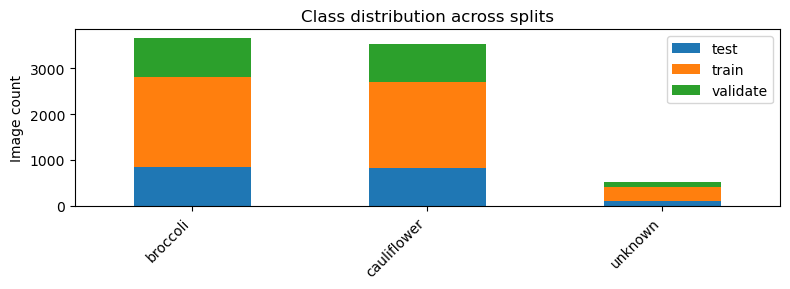

In [4]:
def count_images(split):
    return {cls: len(list((ROOT/split/cls).iterdir()))
            for cls in classes}
df_counts = pd.DataFrame({s: count_images(s) for s in splits}).T
display(df_counts)  # nice Jupyter table
ax = df_counts.T.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


2025-07-10 22:23:11.972129: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


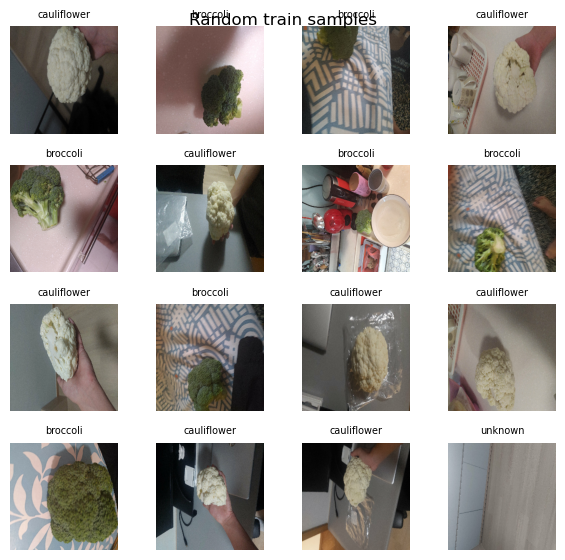

In [5]:
plt.figure(figsize=(6,6))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()


2025-07-10 22:23:14.294587: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


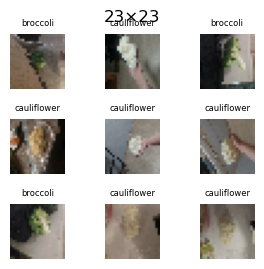

In [6]:
TARGET = 23
sample = (
    train_ds
      .map(lambda x,y: (tf.image.resize(x, [TARGET,TARGET]) / 255.0, y))
      .unbatch()
      .take(9)
)
plt.figure(figsize=(3,3))
for i, (img, lbl) in enumerate(sample):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(img.numpy().squeeze(), cmap="gray")
    plt.title(classes[np.argmax(lbl)], fontsize=6)
    plt.axis("off")
plt.suptitle(f"{TARGET}×{TARGET}", y=0.88)
plt.tight_layout()
plt.show()

In [7]:
CANON_CLASSES = sorted([p.name for p in (ROOT/"train").iterdir() if p.is_dir()])
NUM_CLASSES   = len(CANON_CLASSES)
TARGET_SIZES  = {               # the two resolutions you must experiment with
    "small":  23,
    "medium": 101
}
AUTOTUNE = tf.data.AUTOTUNE

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, regularizers, Sequential
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras_tuner import RandomSearch

# Early stopping / checkpoint / LR reduction
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True)

lr_reduce = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

ckpt23 = callbacks.ModelCheckpoint(
    "best_23x23.h5", monitor="val_loss", save_best_only=True)

ckpt101 = callbacks.ModelCheckpoint(
    "best_101x101.h5", monitor="val_loss", save_best_only=True)

In [9]:
import tensorflow as tf
from tensorflow.keras import layers

AUTOTUNE   = tf.data.AUTOTUNE
IMG_SIZE   = (224,224)  # load at original size first
BATCH_SIZE = 32
LABEL_MODE = "categorical"
SEED       = 88

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

def make_ds(split, target_size, augment=False):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ROOT/split,
        seed=SEED,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode=LABEL_MODE,
        class_names=CANON_CLASSES
    )
    def _prep(img, lbl):
        img = tf.image.rgb_to_grayscale(img)
        img = tf.image.resize(img, [target_size, target_size])
        img = img / 255.0
        if augment:
            img = data_augmentation(img)
        return img, lbl

    ds = ds.map(_prep, num_parallel_calls=AUTOTUNE)
    if split == "train":
        ds = ds.shuffle(1024, seed=SEED)
    return ds.prefetch(AUTOTUNE)

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers

# ─────────────────────────────────────────────────────────────────────────────
# Model A: small capacity for 23×23 grayscale inputs
# ─────────────────────────────────────────────────────────────────────────────
def build_baseline_23(input_size=TARGET_SIZES["small"], num_classes=NUM_CLASSES):
    
    model = Sequential(name="baseline_23x23")
    
    # Conv block 1
    model.add(layers.InputLayer(input_shape=(input_size, input_size, 1)))
    model.add(layers.Conv2D(32, (5,5), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Dropout(0.35))    
    # Conv block 2
    model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Dropout(0.35))

    model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(2,2))
    model.add(layers.Dropout(0.35))
    
    # Classifier head
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(3, activation="softmax"))
    
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [18]:
with tf.device('/CPU:0'):
    ds23_train = make_ds("train", TARGET_SIZES["small"], augment=False)
    ds23_val   = make_ds("validate", TARGET_SIZES["small"], augment=False)
    ds23_test  = make_ds("test", TARGET_SIZES["small"], augment=False)


Found 4148 files belonging to 3 classes.
Found 1788 files belonging to 3 classes.
Found 1785 files belonging to 3 classes.


In [21]:
with tf.device('/CPU:0'):
    model23_do = build_baseline_23(TARGET_SIZES["small"])
    history23_do = model23_do.fit(
        ds23_train,
        validation_data=ds23_val,
        epochs=50,
        callbacks=[early_stop, ckpt23, lr_reduce],
        verbose=1
    )
    
    loss23_do, acc23_do = model23_do.evaluate(ds23_test, verbose=0)
    print(f"📈 23×23 w/ Dropout test accuracy: {acc23_do:.2%}")

Epoch 1/50


/home/me/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-07-10 22:44:07.821379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 104 of 1024
2025-07-10 22:44:10.276110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.5706 - loss: 0.8720 - val_accuracy: 0.7959 - val_loss: 0.5130 - learning_rate: 0.0010
Epoch 2/50


2025-07-10 22:44:30.022211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 108 of 1024


 11/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7715 - loss: 0.6217

2025-07-10 22:44:32.094108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.7885 - loss: 0.5484 - val_accuracy: 0.8468 - val_loss: 0.4357 - learning_rate: 0.0010
Epoch 3/50


2025-07-10 22:44:49.570316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 102 of 1024


 13/130 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8526 - loss: 0.4149

2025-07-10 22:44:52.282638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.8256 - loss: 0.4363 - val_accuracy: 0.8876 - val_loss: 0.3204 - learning_rate: 0.0010
Epoch 4/50


2025-07-10 22:45:10.177809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 103 of 1024


 12/130 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8650 - loss: 0.3032

2025-07-10 22:45:12.703813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.8761 - loss: 0.3221 - val_accuracy: 0.9211 - val_loss: 0.2524 - learning_rate: 0.0010
Epoch 5/50


2025-07-10 22:45:30.517967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 106 of 1024


  8/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9259 - loss: 0.2133

2025-07-10 22:45:32.720422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.9158 - loss: 0.2491 - val_accuracy: 0.9318 - val_loss: 0.2229 - learning_rate: 0.0010
Epoch 6/50


2025-07-10 22:45:50.568502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 110 of 1024


  8/130 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9353 - loss: 0.1921

2025-07-10 22:45:52.274172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.9248 - loss: 0.2130 - val_accuracy: 0.9290 - val_loss: 0.2033 - learning_rate: 0.0010
Epoch 7/50


2025-07-10 22:46:10.591948: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 115 of 1024


 12/130 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9473 - loss: 0.1844

2025-07-10 22:46:11.823913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9424 - loss: 0.1642 - val_accuracy: 0.9525 - val_loss: 0.1620 - learning_rate: 0.0010
Epoch 8/50


2025-07-10 22:46:29.514355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 113 of 1024


 11/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9617 - loss: 0.1201

2025-07-10 22:46:30.997492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9525 - loss: 0.1409 - val_accuracy: 0.9575 - val_loss: 0.1477 - learning_rate: 0.0010
Epoch 9/50


2025-07-10 22:46:48.875538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 108 of 1024


 10/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9387 - loss: 0.1450

2025-07-10 22:46:50.840923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.9472 - loss: 0.1326 - val_accuracy: 0.9547 - val_loss: 0.1511 - learning_rate: 0.0010
Epoch 10/50


2025-07-10 22:47:08.676950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 104 of 1024


 10/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9576 - loss: 0.1132

2025-07-10 22:47:11.146400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9535 - loss: 0.1275 - val_accuracy: 0.9653 - val_loss: 0.1221 - learning_rate: 0.0010
Epoch 11/50


2025-07-10 22:47:28.301587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 100 of 1024


 10/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9608 - loss: 0.1078

2025-07-10 22:47:31.217164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.9655 - loss: 0.0956 - val_accuracy: 0.9732 - val_loss: 0.1025 - learning_rate: 0.0010
Epoch 12/50


2025-07-10 22:47:48.212914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 100 of 1024


  9/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9534 - loss: 0.1136

2025-07-10 22:47:51.155371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9551 - loss: 0.1231 - val_accuracy: 0.9709 - val_loss: 0.1033 - learning_rate: 0.0010
Epoch 13/50


2025-07-10 22:48:08.762358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 104 of 1024


 11/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9598 - loss: 0.0885

2025-07-10 22:48:11.194703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9679 - loss: 0.0940 - val_accuracy: 0.9799 - val_loss: 0.0735 - learning_rate: 0.0010
Epoch 14/50


2025-07-10 22:48:28.516140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 103 of 1024


 10/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9911 - loss: 0.0343

2025-07-10 22:48:31.209079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.9783 - loss: 0.0681 - val_accuracy: 0.9760 - val_loss: 0.0874 - learning_rate: 0.0010
Epoch 15/50


2025-07-10 22:48:48.414644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 108 of 1024


 12/130 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9919 - loss: 0.0305

2025-07-10 22:48:50.355903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.9708 - loss: 0.0803 - val_accuracy: 0.9463 - val_loss: 0.1598 - learning_rate: 0.0010
Epoch 16/50


2025-07-10 22:49:07.907024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 120 of 1024


  8/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9638 - loss: 0.1075

2025-07-10 22:49:08.679171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9734 - loss: 0.0745 - val_accuracy: 0.9787 - val_loss: 0.0751 - learning_rate: 0.0010
Epoch 17/50


2025-07-10 22:49:26.353025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 112 of 1024


 11/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9690 - loss: 0.0717

2025-07-10 22:49:27.949293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9827 - loss: 0.0485 - val_accuracy: 0.9787 - val_loss: 0.0831 - learning_rate: 5.0000e-04
Epoch 18/50


2025-07-10 22:49:45.631446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 113 of 1024


 10/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9798 - loss: 0.0716

2025-07-10 22:49:47.085614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.9859 - loss: 0.0428 - val_accuracy: 0.9832 - val_loss: 0.0616 - learning_rate: 5.0000e-04
Epoch 19/50


2025-07-10 22:50:04.477035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 105 of 1024


 10/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9767 - loss: 0.0509

2025-07-10 22:50:06.803730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9859 - loss: 0.0377 - val_accuracy: 0.9855 - val_loss: 0.0593 - learning_rate: 5.0000e-04
Epoch 20/50


2025-07-10 22:50:24.094049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 106 of 1024


 11/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9848 - loss: 0.0639

2025-07-10 22:50:26.414189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9836 - loss: 0.0511 - val_accuracy: 0.9843 - val_loss: 0.0514 - learning_rate: 5.0000e-04
Epoch 21/50


2025-07-10 22:50:43.390358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 103 of 1024


 11/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9830 - loss: 0.0270

2025-07-10 22:50:46.080188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9889 - loss: 0.0358 - val_accuracy: 0.9843 - val_loss: 0.0623 - learning_rate: 5.0000e-04
Epoch 22/50


2025-07-10 22:51:03.898174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 103 of 1024


 10/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9946 - loss: 0.0136

2025-07-10 22:51:06.471258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9880 - loss: 0.0300 - val_accuracy: 0.9871 - val_loss: 0.0498 - learning_rate: 5.0000e-04
Epoch 23/50


2025-07-10 22:51:23.873930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 104 of 1024


 10/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9894 - loss: 0.0309

2025-07-10 22:51:26.285508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9878 - loss: 0.0358 - val_accuracy: 0.9871 - val_loss: 0.0567 - learning_rate: 5.0000e-04
Epoch 24/50


2025-07-10 22:51:43.320711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 118 of 1024


 11/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9877 - loss: 0.0224

2025-07-10 22:51:44.286623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.9900 - loss: 0.0311 - val_accuracy: 0.9849 - val_loss: 0.0590 - learning_rate: 5.0000e-04
Epoch 25/50


2025-07-10 22:52:01.620322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 116 of 1024


 11/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9932 - loss: 0.0318

2025-07-10 22:52:02.770000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.9926 - loss: 0.0275 - val_accuracy: 0.9843 - val_loss: 0.0515 - learning_rate: 5.0000e-04
Epoch 26/50


2025-07-10 22:52:20.308878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 110 of 1024


 11/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9825 - loss: 0.0498

2025-07-10 22:52:22.096696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.9915 - loss: 0.0260 - val_accuracy: 0.9860 - val_loss: 0.0442 - learning_rate: 2.5000e-04
Epoch 27/50


2025-07-10 22:52:39.487968: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 114 of 1024


  7/130 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 0.0058

2025-07-10 22:52:40.851324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.9926 - loss: 0.0232 - val_accuracy: 0.9883 - val_loss: 0.0412 - learning_rate: 2.5000e-04
Epoch 28/50


2025-07-10 22:52:58.358416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 107 of 1024


 11/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9973 - loss: 0.0148

2025-07-10 22:53:00.495746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9919 - loss: 0.0273 - val_accuracy: 0.9888 - val_loss: 0.0428 - learning_rate: 2.5000e-04
Epoch 29/50


2025-07-10 22:53:17.825220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 103 of 1024


 11/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9871 - loss: 0.0220

2025-07-10 22:53:20.444284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9921 - loss: 0.0200 - val_accuracy: 0.9871 - val_loss: 0.0506 - learning_rate: 2.5000e-04
Epoch 30/50


2025-07-10 22:53:37.633639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 106 of 1024


 11/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9934 - loss: 0.0185

2025-07-10 22:53:39.878248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.9920 - loss: 0.0233 - val_accuracy: 0.9877 - val_loss: 0.0449 - learning_rate: 2.5000e-04
Epoch 31/50


2025-07-10 22:53:57.399157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 107 of 1024


 11/130 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 0.0129

2025-07-10 22:53:59.469782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.9976 - loss: 0.0146 - val_accuracy: 0.9871 - val_loss: 0.0464 - learning_rate: 1.2500e-04
Epoch 32/50


2025-07-10 22:54:16.644653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:94: Filling up shuffle buffer (this may take a while): 108 of 1024


 10/130 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9974 - loss: 0.0193

2025-07-10 22:54:18.581176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9951 - loss: 0.0181 - val_accuracy: 0.9877 - val_loss: 0.0436 - learning_rate: 1.2500e-04
📈 23×23 w/ Dropout test accuracy: 98.60%


In [ ]:
import itertools
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint

# ─────────────────────────────────────────────────────────────────────────────
# 1) Builder with exactly 4 Conv2D blocks, tunable head_units, lr & conv_dropout
# ─────────────────────────────────────────────────────────────────────────────
def build_baseline_101_tuned(
    input_size=TARGET_SIZES["medium"],
    num_classes=NUM_CLASSES,
    conv_drop=0.3,
    head_units=256,
    lr=1e-4
):
    model = Sequential(name=f"bs101_cd{conv_drop}_hu{head_units}_lr{lr}")
    model.add(layers.InputLayer(input_shape=(input_size, input_size, 1)))

    # ── 4 Conv2D blocks ───────────────────────────────────────
    # Block 1
    model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(32, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D((2,2)))   # 101→50
    model.add(layers.Dropout(conv_drop))

    # Block 2
    model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D((2,2)))   # 50→25
    model.add(layers.Dropout(conv_drop))

    # Block 3
    model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(128, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D((2,2)))   # 25→12
    model.add(layers.Dropout(conv_drop))

    # Block 4
    model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
    model.add(layers.Conv2D(256, (3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D((2,2)))   # 12→6
    model.add(layers.Dropout(conv_drop))

    # ── Global pooling + tunable head + output ───────────────
    model.add(layers.GlobalAveragePooling2D())             # 6×6×256 → 256
    model.add(layers.Dropout(conv_drop + 0.1))
    model.add(layers.Dense(head_units, activation="relu")) # <— tunable
    model.add(layers.Dropout(conv_drop + 0.1))
    model.add(layers.Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ─────────────────────────────────────────────────────────────────────────────
# 2) Hyperparameter grids
# ─────────────────────────────────────────────────────────────────────────────
head_units_grid = [128, 256, 512]   # second-last Dense layer size
lr_grid         = [1e-3, 1e-4]      # learning rates to try
batch_grid      = [32, 64]          # batch sizes
dropout_grid    = [0.25, 0.35]      # conv-block dropout rates

# ─────────────────────────────────────────────────────────────────────────────
# 3) Callbacks & base datasets
# ─────────────────────────────────────────────────────────────────────────────
with tf.device("/CPU:0"):
    early_stop = callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    )
    temp_ckpt = "temp_best.weights.h5"
    best_ckpt = "best_101.weights.h5"
    
    ds_train_base = make_ds("train", TARGET_SIZES["medium"], augment=True).unbatch()
    ds_val_base   = make_ds("validate", TARGET_SIZES["medium"], augment=False).unbatch()
    
    # ─────────────────────────────────────────────────────────────────────────────
    # 4) Grid search
    # ─────────────────────────────────────────────────────────────────────────────
    best_overall = {"val_acc": 0.0}
    results = []
    
    for head_units, lr, batch_size, conv_drop in itertools.product(
        head_units_grid, lr_grid, batch_grid, dropout_grid
    ):
        print(f"\n>>> Testing head={head_units}, lr={lr}, bs={batch_size}, drop={conv_drop}")
        model = build_baseline_101_tuned(
            conv_drop=conv_drop,
            head_units=head_units,
            lr=lr
        )
    
        # checkpoint to capture best epoch of this run
        ckpt = ModelCheckpoint(
            temp_ckpt,
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=True,
            verbose=0
        )
    
        # re-batch
        ds_train = ds_train_base.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        ds_val   = ds_val_base.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
        # train with one-line/epoch logs
        history = model.fit(
            ds_train,
            validation_data=ds_val,
            epochs=20,
            callbacks=[early_stop, ckpt],
            verbose=2
        )
    
        # load best-epoch weights, evaluate
        model.load_weights(temp_ckpt)
        _, val_acc = model.evaluate(ds_val, verbose=0)
    
        results.append({
            "head_units": head_units,
            "learning_rate": lr,
            "batch_size": batch_size,
            "conv_dropout": conv_drop,
            "val_acc": val_acc
        })
    
        # save best overall
        if val_acc > best_overall["val_acc"]:
            best_overall = results[-1].copy()
            model.save_weights(best_ckpt)

# ─────────────────────────────────────────────────────────────────────────────
# 5) Report top configs & best
# ─────────────────────────────────────────────────────────────────────────────
results.sort(key=lambda x: x["val_accuracy"], reverse=True)
print("\nTop 5 configurations:")
for r in results[:5]:
    print(r)

print("\nBest overall:")
print(best_overall)
print(f"Best weights saved to: {best_ckpt}")

Found 4148 files belonging to 3 classes.
Found 1788 files belonging to 3 classes.

>>> Testing head=128, lr=0.001, bs=32, drop=0.25
Epoch 1/20


/home/me/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-07-10 23:26:22.102136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-10 23:26:25.363208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
/home/me/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 - 108s - 834ms/step - accuracy: 0.4617 - loss: 0.9202 - val_accuracy: 0.4754 - val_loss: 0.8573
Epoch 2/20


2025-07-10 23:28:09.369033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 91 of 1024
2025-07-10 23:28:15.398867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 105s - 804ms/step - accuracy: 0.4759 - loss: 0.8960 - val_accuracy: 0.4631 - val_loss: 0.8576
Epoch 3/20


2025-07-10 23:29:53.900938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 95 of 1024
2025-07-10 23:29:57.487225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 799ms/step - accuracy: 0.4703 - loss: 0.8904 - val_accuracy: 0.4754 - val_loss: 0.8705
Epoch 4/20


2025-07-10 23:31:37.845322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 97 of 1024
2025-07-10 23:31:40.997099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 793ms/step - accuracy: 0.5251 - loss: 0.8768 - val_accuracy: 0.6040 - val_loss: 0.8248
Epoch 5/20


2025-07-10 23:33:20.980619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 94 of 1024
2025-07-10 23:33:24.670190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 102s - 788ms/step - accuracy: 0.6041 - loss: 0.8417 - val_accuracy: 0.6572 - val_loss: 0.7922
Epoch 6/20


2025-07-10 23:35:03.457142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 101 of 1024
2025-07-10 23:35:06.277414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 774ms/step - accuracy: 0.5251 - loss: 0.8818 - val_accuracy: 0.4631 - val_loss: 0.8840
Epoch 7/20


2025-07-10 23:36:43.945341: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 99 of 1024
2025-07-10 23:36:46.993853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 774ms/step - accuracy: 0.4740 - loss: 0.9064 - val_accuracy: 0.4754 - val_loss: 0.8839
Epoch 8/20


2025-07-10 23:38:24.505222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 100 of 1024
2025-07-10 23:38:27.460656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 798ms/step - accuracy: 0.4532 - loss: 0.9060 - val_accuracy: 0.4754 - val_loss: 0.8844

>>> Testing head=128, lr=0.001, bs=32, drop=0.35
Epoch 1/20


2025-07-10 23:40:22.070452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 95 of 1024
2025-07-10 23:40:25.670657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 108s - 829ms/step - accuracy: 0.4757 - loss: 0.9255 - val_accuracy: 0.4754 - val_loss: 0.8739
Epoch 2/20


2025-07-10 23:42:08.576176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-10 23:42:12.006160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 800ms/step - accuracy: 0.4952 - loss: 0.8947 - val_accuracy: 0.5973 - val_loss: 0.8708
Epoch 3/20


2025-07-10 23:43:52.549983: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 99 of 1024
2025-07-10 23:43:55.697483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 105s - 811ms/step - accuracy: 0.6774 - loss: 0.7460 - val_accuracy: 0.5375 - val_loss: 1.0768
Epoch 4/20


2025-07-10 23:45:38.000220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 101 of 1024
2025-07-10 23:45:40.840456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 775ms/step - accuracy: 0.7235 - loss: 0.6788 - val_accuracy: 0.6700 - val_loss: 0.7112
Epoch 5/20


2025-07-10 23:47:18.700496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 94 of 1024
2025-07-10 23:47:22.394624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 790ms/step - accuracy: 0.7866 - loss: 0.5781 - val_accuracy: 0.6600 - val_loss: 0.7830
Epoch 6/20


2025-07-10 23:49:01.387659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-10 23:49:04.657501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 780ms/step - accuracy: 0.8158 - loss: 0.5244 - val_accuracy: 0.8579 - val_loss: 0.4297
Epoch 7/20


2025-07-10 23:50:32.707170: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-07-10 23:50:42.851503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 100 of 1024
2025-07-10 23:50:45.855299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 779ms/step - accuracy: 0.8529 - loss: 0.4230 - val_accuracy: 0.8630 - val_loss: 0.3541
Epoch 8/20


2025-07-10 23:52:24.045899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-10 23:52:27.300560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 778ms/step - accuracy: 0.8664 - loss: 0.3806 - val_accuracy: 0.7858 - val_loss: 0.5519
Epoch 9/20


2025-07-10 23:54:05.330573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-10 23:54:08.892961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 780ms/step - accuracy: 0.8826 - loss: 0.3400 - val_accuracy: 0.7595 - val_loss: 0.6441
Epoch 10/20


2025-07-10 23:55:46.625219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-10 23:55:49.818722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 776ms/step - accuracy: 0.8867 - loss: 0.3273 - val_accuracy: 0.8904 - val_loss: 0.3005
Epoch 11/20


2025-07-10 23:57:27.536500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 97 of 1024
2025-07-10 23:57:30.897340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 102s - 784ms/step - accuracy: 0.8889 - loss: 0.3175 - val_accuracy: 0.9189 - val_loss: 0.2326
Epoch 12/20


2025-07-10 23:59:09.384121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-10 23:59:12.597359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 777ms/step - accuracy: 0.9028 - loss: 0.2843 - val_accuracy: 0.9167 - val_loss: 0.2324
Epoch 13/20


2025-07-11 00:00:50.437016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 00:00:53.675723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 779ms/step - accuracy: 0.9009 - loss: 0.2747 - val_accuracy: 0.8803 - val_loss: 0.3079
Epoch 14/20


2025-07-11 00:02:31.642363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 00:02:35.164069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 780ms/step - accuracy: 0.9154 - loss: 0.2419 - val_accuracy: 0.9334 - val_loss: 0.1815
Epoch 15/20


2025-07-11 00:04:13.163775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 101 of 1024
2025-07-11 00:04:16.033550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 100s - 773ms/step - accuracy: 0.9200 - loss: 0.2289 - val_accuracy: 0.9239 - val_loss: 0.2205
Epoch 16/20


2025-07-11 00:05:53.616570: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 99 of 1024
2025-07-11 00:05:56.756388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 777ms/step - accuracy: 0.9176 - loss: 0.2244 - val_accuracy: 0.9228 - val_loss: 0.2181
Epoch 17/20


2025-07-11 00:07:34.633308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 97 of 1024
2025-07-11 00:07:38.040225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 777ms/step - accuracy: 0.9253 - loss: 0.1967 - val_accuracy: 0.9413 - val_loss: 0.1716
Epoch 18/20


2025-07-11 00:09:15.707386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 00:09:18.897112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 100s - 772ms/step - accuracy: 0.9200 - loss: 0.2169 - val_accuracy: 0.9323 - val_loss: 0.1885
Epoch 19/20


2025-07-11 00:10:56.108875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 00:10:59.232484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 100s - 771ms/step - accuracy: 0.9245 - loss: 0.2089 - val_accuracy: 0.8613 - val_loss: 0.3478
Epoch 20/20


2025-07-11 00:12:36.270178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 00:12:39.496417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 100s - 773ms/step - accuracy: 0.9378 - loss: 0.1746 - val_accuracy: 0.8641 - val_loss: 0.4083

>>> Testing head=128, lr=0.001, bs=64, drop=0.25
Epoch 1/20


2025-07-11 00:14:30.499162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 100 of 1024
2025-07-11 00:14:33.474542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 108s - 2s/step - accuracy: 0.4518 - loss: 0.9419 - val_accuracy: 0.4754 - val_loss: 0.8821
Epoch 2/20


2025-07-11 00:16:16.554508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 102 of 1024
2025-07-11 00:16:19.168002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 102s - 2s/step - accuracy: 0.4728 - loss: 0.8920 - val_accuracy: 0.4754 - val_loss: 0.8524
Epoch 3/20


2025-07-11 00:17:58.193060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 100 of 1024
2025-07-11 00:18:01.165384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 102s - 2s/step - accuracy: 0.4928 - loss: 0.8910 - val_accuracy: 0.5442 - val_loss: 0.8430
Epoch 4/20


2025-07-11 00:19:40.057599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 00:19:43.224736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 102s - 2s/step - accuracy: 0.6025 - loss: 0.8159 - val_accuracy: 0.6270 - val_loss: 0.7843
Epoch 5/20


2025-07-11 00:21:22.434232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 00:21:25.655294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 102s - 2s/step - accuracy: 0.7792 - loss: 0.5920 - val_accuracy: 0.7315 - val_loss: 0.6490
Epoch 6/20


2025-07-11 00:23:04.581037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 100 of 1024
2025-07-11 00:23:07.548766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 102s - 2s/step - accuracy: 0.8194 - loss: 0.4947 - val_accuracy: 0.8160 - val_loss: 0.5046
Epoch 7/20


2025-07-11 00:24:46.379495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 00:24:49.528161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 102s - 2s/step - accuracy: 0.8404 - loss: 0.4507 - val_accuracy: 0.8283 - val_loss: 0.4357
Epoch 8/20


2025-07-11 00:26:28.395696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 100 of 1024
2025-07-11 00:26:31.387245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 102s - 2s/step - accuracy: 0.8529 - loss: 0.4241 - val_accuracy: 0.8216 - val_loss: 0.4753
Epoch 9/20


2025-07-11 00:28:10.143199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 100 of 1024
2025-07-11 00:28:13.120516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 102s - 2s/step - accuracy: 0.8662 - loss: 0.3827 - val_accuracy: 0.7411 - val_loss: 0.7551
Epoch 10/20


2025-07-11 00:29:52.031116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 00:29:55.654043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 103s - 2s/step - accuracy: 0.8643 - loss: 0.3819 - val_accuracy: 0.8529 - val_loss: 0.4000
Epoch 11/20


2025-07-11 00:31:35.047928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 00:31:38.197214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 103s - 2s/step - accuracy: 0.8898 - loss: 0.3053 - val_accuracy: 0.8820 - val_loss: 0.3113
Epoch 12/20


2025-07-11 00:33:17.771162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 103 of 1024
2025-07-11 00:33:20.325190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 101s - 2s/step - accuracy: 0.8881 - loss: 0.2987 - val_accuracy: 0.8641 - val_loss: 0.3369
Epoch 13/20


2025-07-11 00:34:59.180813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 101 of 1024
2025-07-11 00:35:02.081179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 102s - 2s/step - accuracy: 0.8966 - loss: 0.2814 - val_accuracy: 0.8865 - val_loss: 0.2897
Epoch 14/20


2025-07-11 00:36:41.605764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 100 of 1024
2025-07-11 00:36:44.482388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 102s - 2s/step - accuracy: 0.9041 - loss: 0.2598 - val_accuracy: 0.8988 - val_loss: 0.2663
Epoch 15/20


2025-07-11 00:38:23.755994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 99 of 1024
2025-07-11 00:38:26.772339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 103s - 2s/step - accuracy: 0.9077 - loss: 0.2495 - val_accuracy: 0.9066 - val_loss: 0.2290
Epoch 16/20


2025-07-11 00:40:06.511363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 97 of 1024
2025-07-11 00:40:09.704469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 103s - 2s/step - accuracy: 0.9130 - loss: 0.2408 - val_accuracy: 0.9139 - val_loss: 0.2207
Epoch 17/20


2025-07-11 00:41:49.202498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 99 of 1024
2025-07-11 00:41:52.210083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 102s - 2s/step - accuracy: 0.9274 - loss: 0.2102 - val_accuracy: 0.9200 - val_loss: 0.1977
Epoch 18/20


2025-07-11 00:43:31.421545: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 100 of 1024
2025-07-11 00:43:34.285561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-07-11 00:44:51.333127: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


65/65 - 102s - 2s/step - accuracy: 0.9378 - loss: 0.1864 - val_accuracy: 0.8971 - val_loss: 0.2628
Epoch 19/20


2025-07-11 00:45:13.193366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 99 of 1024
2025-07-11 00:45:16.263527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 102s - 2s/step - accuracy: 0.9332 - loss: 0.1966 - val_accuracy: 0.9413 - val_loss: 0.1520
Epoch 20/20


2025-07-11 00:46:55.255505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 00:46:58.664253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 102s - 2s/step - accuracy: 0.9364 - loss: 0.1830 - val_accuracy: 0.9256 - val_loss: 0.1945

>>> Testing head=128, lr=0.001, bs=64, drop=0.35
Epoch 1/20


2025-07-11 00:48:51.309095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 00:48:54.497133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 110s - 2s/step - accuracy: 0.4660 - loss: 0.9304 - val_accuracy: 0.4754 - val_loss: 0.8647
Epoch 2/20


2025-07-11 00:50:39.426200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 00:50:42.902240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 104s - 2s/step - accuracy: 0.4732 - loss: 0.8985 - val_accuracy: 0.5151 - val_loss: 0.8500
Epoch 3/20


2025-07-11 00:52:23.179052: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 97 of 1024
2025-07-11 00:52:26.497371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 104s - 2s/step - accuracy: 0.5248 - loss: 0.8680 - val_accuracy: 0.6320 - val_loss: 0.8047
Epoch 4/20


2025-07-11 00:54:06.861761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 00:54:10.069699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 103s - 2s/step - accuracy: 0.7249 - loss: 0.6834 - val_accuracy: 0.7478 - val_loss: 0.6275
Epoch 5/20


2025-07-11 00:55:50.227509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 99 of 1024
2025-07-11 00:55:53.351461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 103s - 2s/step - accuracy: 0.7922 - loss: 0.5715 - val_accuracy: 0.7735 - val_loss: 0.5763
Epoch 6/20


2025-07-11 00:57:33.270885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 94 of 1024
2025-07-11 00:57:36.903539: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 104s - 2s/step - accuracy: 0.8076 - loss: 0.5317 - val_accuracy: 0.7673 - val_loss: 0.5853
Epoch 7/20


2025-07-11 00:59:17.084675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 00:59:20.279229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 103s - 2s/step - accuracy: 0.8426 - loss: 0.4521 - val_accuracy: 0.8350 - val_loss: 0.4422
Epoch 8/20


2025-07-11 01:01:00.381428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 97 of 1024
2025-07-11 01:01:03.754498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 103s - 2s/step - accuracy: 0.8455 - loss: 0.4526 - val_accuracy: 0.7260 - val_loss: 0.7568
Epoch 9/20


2025-07-11 01:02:43.745153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 01:02:47.129703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 103s - 2s/step - accuracy: 0.8621 - loss: 0.3837 - val_accuracy: 0.8423 - val_loss: 0.4243
Epoch 10/20


2025-07-11 01:04:27.267122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 01:04:30.501493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 103s - 2s/step - accuracy: 0.8758 - loss: 0.3633 - val_accuracy: 0.7237 - val_loss: 0.7599
Epoch 11/20


2025-07-11 01:06:10.539527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 01:06:14.152142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 104s - 2s/step - accuracy: 0.8742 - loss: 0.3597 - val_accuracy: 0.8563 - val_loss: 0.3667
Epoch 12/20


2025-07-11 01:07:54.532674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 01:07:57.664799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 103s - 2s/step - accuracy: 0.8867 - loss: 0.3176 - val_accuracy: 0.8585 - val_loss: 0.3856
Epoch 13/20


2025-07-11 01:09:37.670165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 97 of 1024
2025-07-11 01:09:40.926941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 103s - 2s/step - accuracy: 0.8713 - loss: 0.3673 - val_accuracy: 0.8372 - val_loss: 0.4150
Epoch 14/20


2025-07-11 01:11:20.799481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 97 of 1024
2025-07-11 01:11:24.140534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 103s - 2s/step - accuracy: 0.8959 - loss: 0.2962 - val_accuracy: 0.8065 - val_loss: 0.5558

>>> Testing head=128, lr=0.0001, bs=32, drop=0.25
Epoch 1/20


2025-07-11 01:13:17.655934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 99 of 1024
2025-07-11 01:13:20.641885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 108s - 831ms/step - accuracy: 0.4699 - loss: 0.9263 - val_accuracy: 0.4754 - val_loss: 0.8802
Epoch 2/20


2025-07-11 01:15:03.900557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 97 of 1024
2025-07-11 01:15:07.253180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 802ms/step - accuracy: 0.4740 - loss: 0.8807 - val_accuracy: 0.4804 - val_loss: 0.8311
Epoch 3/20


2025-07-11 01:16:48.168063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 97 of 1024
2025-07-11 01:16:51.537917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 799ms/step - accuracy: 0.5581 - loss: 0.8451 - val_accuracy: 0.6012 - val_loss: 0.7925
Epoch 4/20


2025-07-11 01:18:31.989767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 01:18:35.510730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 798ms/step - accuracy: 0.7290 - loss: 0.6750 - val_accuracy: 0.6544 - val_loss: 0.7879
Epoch 5/20


2025-07-11 01:20:15.690025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 99 of 1024
2025-07-11 01:20:18.821992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 790ms/step - accuracy: 0.7854 - loss: 0.5742 - val_accuracy: 0.7164 - val_loss: 0.7023
Epoch 6/20


2025-07-11 01:21:58.507580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 01:22:01.902705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 797ms/step - accuracy: 0.8040 - loss: 0.5290 - val_accuracy: 0.6482 - val_loss: 1.0459
Epoch 7/20


2025-07-11 01:23:42.083505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 93 of 1024
2025-07-11 01:23:45.769145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 800ms/step - accuracy: 0.8226 - loss: 0.4792 - val_accuracy: 0.7388 - val_loss: 0.6733
Epoch 8/20


2025-07-11 01:25:25.985195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 95 of 1024
2025-07-11 01:25:29.486899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 797ms/step - accuracy: 0.8394 - loss: 0.4468 - val_accuracy: 0.7053 - val_loss: 0.8564
Epoch 9/20


2025-07-11 01:27:09.616827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 94 of 1024
2025-07-11 01:27:13.277775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 791ms/step - accuracy: 0.8549 - loss: 0.4112 - val_accuracy: 0.7472 - val_loss: 0.7145
Epoch 10/20


2025-07-11 01:28:52.479271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 01:28:55.969472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 795ms/step - accuracy: 0.8582 - loss: 0.3855 - val_accuracy: 0.7377 - val_loss: 0.6941

>>> Testing head=128, lr=0.0001, bs=32, drop=0.35
Epoch 1/20


2025-07-11 01:31:03.056500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 01:31:06.460131: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 124s - 952ms/step - accuracy: 0.4672 - loss: 0.9318 - val_accuracy: 0.4754 - val_loss: 0.9807
Epoch 2/20


2025-07-11 01:32:52.212512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 99 of 1024
2025-07-11 01:32:55.288151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 802ms/step - accuracy: 0.4711 - loss: 0.9088 - val_accuracy: 0.4754 - val_loss: 0.8709
Epoch 3/20


2025-07-11 01:34:36.394643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 01:34:39.890160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 105s - 806ms/step - accuracy: 0.4867 - loss: 0.8841 - val_accuracy: 0.4799 - val_loss: 0.8428
Epoch 4/20


2025-07-11 01:36:21.214172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 95 of 1024
2025-07-11 01:36:24.779947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 105s - 805ms/step - accuracy: 0.4959 - loss: 0.8749 - val_accuracy: 0.5928 - val_loss: 0.8849
Epoch 5/20


2025-07-11 01:38:05.757090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 01:38:08.971976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 800ms/step - accuracy: 0.5251 - loss: 0.8683 - val_accuracy: 0.5649 - val_loss: 0.8502
Epoch 6/20


2025-07-11 01:39:49.826950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 99 of 1024
2025-07-11 01:39:52.846596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 796ms/step - accuracy: 0.6502 - loss: 0.7767 - val_accuracy: 0.6443 - val_loss: 0.7919
Epoch 7/20


2025-07-11 01:41:33.233520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 01:41:36.647708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 798ms/step - accuracy: 0.7628 - loss: 0.6228 - val_accuracy: 0.6907 - val_loss: 0.8655
Epoch 8/20


2025-07-11 01:43:17.076493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 95 of 1024
2025-07-11 01:43:20.640696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 802ms/step - accuracy: 0.8028 - loss: 0.5409 - val_accuracy: 0.6711 - val_loss: 1.0457
Epoch 9/20


2025-07-11 01:45:01.343473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 01:45:04.801242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 799ms/step - accuracy: 0.8185 - loss: 0.5002 - val_accuracy: 0.7360 - val_loss: 0.7531
Epoch 10/20


2025-07-11 01:46:45.257390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 01:46:48.688109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 800ms/step - accuracy: 0.8382 - loss: 0.4663 - val_accuracy: 0.7220 - val_loss: 0.8351
Epoch 11/20


2025-07-11 01:48:29.196114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 01:48:32.743207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 800ms/step - accuracy: 0.8510 - loss: 0.4283 - val_accuracy: 0.7629 - val_loss: 0.6311
Epoch 12/20


2025-07-11 01:50:13.182505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 01:50:16.647339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 796ms/step - accuracy: 0.8633 - loss: 0.3990 - val_accuracy: 0.7248 - val_loss: 0.8173
Epoch 13/20


2025-07-11 01:51:56.665598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 97 of 1024
2025-07-11 01:51:59.923682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 794ms/step - accuracy: 0.8701 - loss: 0.3716 - val_accuracy: 0.7181 - val_loss: 0.8273
Epoch 14/20


2025-07-11 01:53:39.894391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 94 of 1024
2025-07-11 01:53:43.560574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 104s - 800ms/step - accuracy: 0.8734 - loss: 0.3604 - val_accuracy: 0.7086 - val_loss: 0.9324

>>> Testing head=128, lr=0.0001, bs=64, drop=0.25
Epoch 1/20


2025-07-11 01:55:37.829834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 95 of 1024
2025-07-11 01:55:41.419020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 112s - 2s/step - accuracy: 0.4597 - loss: 0.9560 - val_accuracy: 0.4754 - val_loss: 0.9502
Epoch 2/20


2025-07-11 01:57:28.774682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 01:57:32.301656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 106s - 2s/step - accuracy: 0.4585 - loss: 0.9179 - val_accuracy: 0.4754 - val_loss: 0.9108
Epoch 3/20


2025-07-11 01:59:14.715515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 01:59:17.927260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 106s - 2s/step - accuracy: 0.4725 - loss: 0.8892 - val_accuracy: 0.5000 - val_loss: 0.8780
Epoch 4/20


2025-07-11 02:01:00.352286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 02:01:03.510210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.4788 - loss: 0.8770 - val_accuracy: 0.5050 - val_loss: 0.8382
Epoch 5/20


2025-07-11 02:02:45.592501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 100 of 1024
2025-07-11 02:02:48.525171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 106s - 2s/step - accuracy: 0.5140 - loss: 0.8673 - val_accuracy: 0.6130 - val_loss: 0.8220
Epoch 6/20


2025-07-11 02:04:31.194878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 73 of 1024
2025-07-11 02:04:36.989109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 108s - 2s/step - accuracy: 0.5784 - loss: 0.8419 - val_accuracy: 0.5179 - val_loss: 0.8957
Epoch 7/20


2025-07-11 02:06:19.590523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 96 of 1024
2025-07-11 02:06:22.980325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 106s - 2s/step - accuracy: 0.6798 - loss: 0.7341 - val_accuracy: 0.7522 - val_loss: 0.6162
Epoch 8/20


2025-07-11 02:08:05.183142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 02:08:08.329938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 104s - 2s/step - accuracy: 0.7678 - loss: 0.6069 - val_accuracy: 0.6555 - val_loss: 0.8554
Epoch 9/20


2025-07-11 02:09:49.426721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 99 of 1024
2025-07-11 02:09:52.470350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.8098 - loss: 0.5139 - val_accuracy: 0.6963 - val_loss: 0.8011
Epoch 10/20


2025-07-11 02:11:34.479817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 98 of 1024
2025-07-11 02:11:37.637201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.8122 - loss: 0.5019 - val_accuracy: 0.7276 - val_loss: 0.6459

>>> Testing head=128, lr=0.0001, bs=64, drop=0.35
Epoch 1/20


2025-07-11 02:13:32.730009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 97 of 1024
2025-07-11 02:13:36.029748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 118s - 2s/step - accuracy: 0.4554 - loss: 0.9517 - val_accuracy: 0.4754 - val_loss: 0.9395
Epoch 2/20


2025-07-11 02:15:29.550937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 100 of 1024
2025-07-11 02:15:32.603995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.4703 - loss: 0.9204 - val_accuracy: 0.4754 - val_loss: 0.9239
Epoch 3/20


2025-07-11 02:17:14.604502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 94 of 1024
2025-07-11 02:17:18.540530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.4636 - loss: 0.8988 - val_accuracy: 0.4771 - val_loss: 0.9128
Epoch 4/20


2025-07-11 02:18:59.827914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 92 of 1024
2025-07-11 02:19:03.607500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 106s - 2s/step - accuracy: 0.4696 - loss: 0.8892 - val_accuracy: 0.4961 - val_loss: 0.8766
Epoch 5/20


2025-07-11 02:20:45.455478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 94 of 1024
2025-07-11 02:20:49.420744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.4834 - loss: 0.8771 - val_accuracy: 0.4950 - val_loss: 0.8429
Epoch 6/20


2025-07-11 02:22:30.475874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 93 of 1024
2025-07-11 02:22:34.867180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 106s - 2s/step - accuracy: 0.5166 - loss: 0.8633 - val_accuracy: 0.5364 - val_loss: 0.8215
Epoch 7/20


2025-07-11 02:24:16.397877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 91 of 1024
2025-07-11 02:24:20.441490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.6683 - loss: 0.7451 - val_accuracy: 0.6191 - val_loss: 0.7847
Epoch 8/20


2025-07-11 02:26:01.616511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 92 of 1024
2025-07-11 02:26:05.748375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.7657 - loss: 0.6170 - val_accuracy: 0.6040 - val_loss: 0.9312
Epoch 9/20


2025-07-11 02:27:46.900625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 67 of 1024
2025-07-11 02:27:55.671648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 110s - 2s/step - accuracy: 0.7917 - loss: 0.5598 - val_accuracy: 0.6046 - val_loss: 0.9808
Epoch 10/20


2025-07-11 02:29:36.726208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 94 of 1024
2025-07-11 02:29:40.262785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.8165 - loss: 0.5202 - val_accuracy: 0.6113 - val_loss: 1.1019

>>> Testing head=256, lr=0.001, bs=32, drop=0.25
Epoch 1/20


2025-07-11 02:31:35.248244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 97 of 1024
2025-07-11 02:31:38.613209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-07-11 02:32:59.419069: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 - 108s - 832ms/step - accuracy: 0.4578 - loss: 0.9169 - val_accuracy: 0.4754 - val_loss: 0.8644
Epoch 2/20


2025-07-11 02:33:21.870011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 91 of 1024
2025-07-11 02:33:26.211318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 789ms/step - accuracy: 0.4728 - loss: 0.8908 - val_accuracy: 0.4754 - val_loss: 0.9302
Epoch 3/20


2025-07-11 02:35:04.511489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 89 of 1024
2025-07-11 02:35:08.979554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 791ms/step - accuracy: 0.4848 - loss: 0.8943 - val_accuracy: 0.4754 - val_loss: 0.8559
Epoch 4/20


2025-07-11 02:36:47.265813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 91 of 1024
2025-07-11 02:36:51.407986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 102s - 782ms/step - accuracy: 0.5335 - loss: 0.8619 - val_accuracy: 0.5979 - val_loss: 0.7747
Epoch 5/20


2025-07-11 02:38:28.927561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 92 of 1024
2025-07-11 02:38:32.698729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 102s - 782ms/step - accuracy: 0.7307 - loss: 0.6631 - val_accuracy: 0.7841 - val_loss: 0.5428
Epoch 6/20


2025-07-11 02:40:10.587074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 93 of 1024
2025-07-11 02:40:14.493907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 101s - 779ms/step - accuracy: 0.8163 - loss: 0.5081 - val_accuracy: 0.7707 - val_loss: 0.5571
Epoch 7/20


2025-07-11 02:41:51.833724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 86 of 1024
2025-07-11 02:41:56.666028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 102s - 788ms/step - accuracy: 0.8517 - loss: 0.4268 - val_accuracy: 0.8132 - val_loss: 0.5001
Epoch 8/20


2025-07-11 02:43:34.275818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 83 of 1024
2025-07-11 02:43:39.725290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 794ms/step - accuracy: 0.8635 - loss: 0.3918 - val_accuracy: 0.8065 - val_loss: 0.4801
Epoch 9/20


2025-07-11 02:45:17.435944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 87 of 1024
2025-07-11 02:45:22.016538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 102s - 788ms/step - accuracy: 0.8621 - loss: 0.3772 - val_accuracy: 0.8635 - val_loss: 0.3484
Epoch 10/20


2025-07-11 02:46:59.966391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 88 of 1024
2025-07-11 02:47:04.844838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 791ms/step - accuracy: 0.8713 - loss: 0.3420 - val_accuracy: 0.8607 - val_loss: 0.3383
Epoch 11/20


2025-07-11 02:48:42.786515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 88 of 1024
2025-07-11 02:48:47.259069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 793ms/step - accuracy: 0.8799 - loss: 0.3258 - val_accuracy: 0.6823 - val_loss: 0.9522
Epoch 12/20


2025-07-11 02:50:25.862788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 86 of 1024
2025-07-11 02:50:30.766082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 791ms/step - accuracy: 0.8843 - loss: 0.3203 - val_accuracy: 0.8048 - val_loss: 0.4326
Epoch 13/20


2025-07-11 02:52:08.925932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 87 of 1024
2025-07-11 02:52:13.785879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 795ms/step - accuracy: 0.9024 - loss: 0.2828 - val_accuracy: 0.8647 - val_loss: 0.3425

>>> Testing head=256, lr=0.001, bs=32, drop=0.35
Epoch 1/20


2025-07-11 02:54:05.691651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 88 of 1024
2025-07-11 02:54:10.306831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 110s - 847ms/step - accuracy: 0.4752 - loss: 0.9172 - val_accuracy: 0.4754 - val_loss: 0.8861
Epoch 2/20


2025-07-11 02:55:54.395500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 86 of 1024
2025-07-11 02:55:59.124404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 791ms/step - accuracy: 0.5046 - loss: 0.9027 - val_accuracy: 0.4754 - val_loss: 0.8818
Epoch 3/20


2025-07-11 02:57:37.242295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 84 of 1024
2025-07-11 02:57:42.630213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 795ms/step - accuracy: 0.4728 - loss: 0.9028 - val_accuracy: 0.4754 - val_loss: 0.8825
Epoch 4/20


2025-07-11 02:59:20.515469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 87 of 1024
2025-07-11 02:59:25.215896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 102s - 787ms/step - accuracy: 0.4588 - loss: 0.9121 - val_accuracy: 0.4754 - val_loss: 0.8893
Epoch 5/20


2025-07-11 03:01:02.830500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 87 of 1024
2025-07-11 03:01:07.477823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


130/130 - 103s - 789ms/step - accuracy: 0.4747 - loss: 0.9039 - val_accuracy: 0.4631 - val_loss: 0.8830

>>> Testing head=256, lr=0.001, bs=64, drop=0.25
Epoch 1/20


2025-07-11 03:02:59.229166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 88 of 1024
2025-07-11 03:03:04.131312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 111s - 2s/step - accuracy: 0.4737 - loss: 0.9222 - val_accuracy: 0.4776 - val_loss: 0.8570
Epoch 2/20


2025-07-11 03:04:48.895377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 85 of 1024
2025-07-11 03:04:53.875390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.4769 - loss: 0.8932 - val_accuracy: 0.5414 - val_loss: 0.8823
Epoch 3/20


2025-07-11 03:06:34.315899: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 86 of 1024
2025-07-11 03:06:39.197210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 106s - 2s/step - accuracy: 0.5661 - loss: 0.8526 - val_accuracy: 0.5895 - val_loss: 0.7862
Epoch 4/20


2025-07-11 03:08:19.710401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 85 of 1024
2025-07-11 03:08:24.899918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.7351 - loss: 0.6595 - val_accuracy: 0.7187 - val_loss: 0.6595
Epoch 5/20


2025-07-11 03:10:05.077500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 86 of 1024
2025-07-11 03:10:10.021507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.7850 - loss: 0.5698 - val_accuracy: 0.7724 - val_loss: 0.5407
Epoch 6/20


2025-07-11 03:11:50.340045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 88 of 1024
2025-07-11 03:11:55.142909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.8276 - loss: 0.4701 - val_accuracy: 0.7578 - val_loss: 0.6493
Epoch 7/20


2025-07-11 03:13:35.263390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 80 of 1024
2025-07-11 03:13:41.538762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 107s - 2s/step - accuracy: 0.8279 - loss: 0.4831 - val_accuracy: 0.7740 - val_loss: 0.5417
Epoch 8/20


2025-07-11 03:15:21.922487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 86 of 1024
2025-07-11 03:15:26.883015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.8551 - loss: 0.4010 - val_accuracy: 0.8848 - val_loss: 0.3366
Epoch 9/20


2025-07-11 03:17:06.909839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 83 of 1024
2025-07-11 03:17:12.585474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 107s - 2s/step - accuracy: 0.8742 - loss: 0.3410 - val_accuracy: 0.8305 - val_loss: 0.4077
Epoch 10/20


2025-07-11 03:18:53.528394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 49 of 1024
2025-07-11 03:19:05.801924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 113s - 2s/step - accuracy: 0.8816 - loss: 0.3244 - val_accuracy: 0.8691 - val_loss: 0.3270
Epoch 11/20


2025-07-11 03:20:46.026462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 85 of 1024
2025-07-11 03:20:51.061208: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.8893 - loss: 0.3005 - val_accuracy: 0.8009 - val_loss: 0.5053
Epoch 12/20


2025-07-11 03:22:31.202562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 82 of 1024
2025-07-11 03:22:38.575364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 108s - 2s/step - accuracy: 0.8852 - loss: 0.3092 - val_accuracy: 0.9049 - val_loss: 0.2720
Epoch 13/20


2025-07-11 03:24:18.899461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 88 of 1024
2025-07-11 03:24:23.490725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 104s - 2s/step - accuracy: 0.8992 - loss: 0.2727 - val_accuracy: 0.9183 - val_loss: 0.2353
Epoch 14/20


2025-07-11 03:26:03.201178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 85 of 1024
2025-07-11 03:26:08.214108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.9057 - loss: 0.2597 - val_accuracy: 0.9144 - val_loss: 0.2390
Epoch 15/20


2025-07-11 03:27:48.591706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 83 of 1024
2025-07-11 03:27:53.896756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.8978 - loss: 0.2656 - val_accuracy: 0.8143 - val_loss: 0.4953
Epoch 16/20


2025-07-11 03:29:34.128724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 87 of 1024
2025-07-11 03:29:38.896003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.9132 - loss: 0.2291 - val_accuracy: 0.9267 - val_loss: 0.1993
Epoch 17/20


2025-07-11 03:31:18.975517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 86 of 1024
2025-07-11 03:31:23.899224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 106s - 2s/step - accuracy: 0.9163 - loss: 0.2214 - val_accuracy: 0.9167 - val_loss: 0.2018
Epoch 18/20


2025-07-11 03:33:04.632226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 86 of 1024
2025-07-11 03:33:09.713972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.9245 - loss: 0.2067 - val_accuracy: 0.9055 - val_loss: 0.2533
Epoch 19/20


2025-07-11 03:34:49.818322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 88 of 1024
2025-07-11 03:34:54.466521: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 105s - 2s/step - accuracy: 0.9224 - loss: 0.2107 - val_accuracy: 0.8043 - val_loss: 0.5301

>>> Testing head=256, lr=0.001, bs=64, drop=0.35
Epoch 1/20


2025-07-11 03:36:56.322435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 79 of 1024
2025-07-11 03:37:02.095071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 122s - 2s/step - accuracy: 0.4694 - loss: 0.9255 - val_accuracy: 0.4754 - val_loss: 0.8591
Epoch 2/20


2025-07-11 03:38:49.489462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 86 of 1024
2025-07-11 03:38:54.562808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 106s - 2s/step - accuracy: 0.4638 - loss: 0.8957 - val_accuracy: 0.4966 - val_loss: 0.8600
Epoch 3/20


2025-07-11 03:40:35.985929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 87 of 1024
2025-07-11 03:40:40.813934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


65/65 - 111s - 2s/step - accuracy: 0.5193 - loss: 0.8740 - val_accuracy: 0.4938 - val_loss: 0.8499
Epoch 4/20


2025-07-11 03:42:27.354773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:207: Filling up shuffle buffer (this may take a while): 87 of 1024
2025-07-11 03:42:34.572365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


In [ ]:
plt.plot(history101_slim.history['accuracy'], label='train acc')
plt.plot(history101_slim.history['val_accuracy'], label='val acc')
plt.legend(); plt.show()

plt.plot(history101_slim.history['loss'], label='train loss')
plt.plot(history101_slim.history['val_loss'], label='val loss')
plt.legend(); plt.show()